# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [53]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a
HopsworksSettings initialized!


In [54]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import importlib
from mlfs.airquality import util
importlib.reload(util)
import os

In [55]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 11, 38, 4, 740304)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [56]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
# location = json.loads(location_str)
# country=location['country']
# city=location['city']
# street=location['street']
# url = location['aqicn_url']
# [country_1,street_1,city_1,url_1,csv_1,lat_1,long_1] = settings.KEY_PARAMS_1.split(',')
# [country_2,street_2,city_2,url_2,csv_2,lat_2,long_2] = settings.KEY_PARAMS_2.split(',')
# [country_3,street_3,city_3,url_3,csv_3,lat_3,long_3] = settings.KEY_PARAMS_3.split(',')
# [country_4,street_4,city_4,url_4,csv_4,lat_4,long_4] = settings.KEY_PARAMS_4.split(',')
# [country_5,street_5,city_5,url_5,csv_5,lat_5,long_5] = settings.KEY_PARAMS_5.split(',')
index = dict()
for i in range(1,6):
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{i}").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    url = location['aqicn_url']
    street=location['street']
    csv = location['csv']
    index[f'sensor_{i}'] = dict()
    index[f'sensor_{i}']['country'] = country
    index[f'sensor_{i}']['city'] = city
    index[f'sensor_{i}']['street'] = street
    index[f'sensor_{i}']['csv'] = csv
    index[f'sensor_{i}']['url'] = url

2025-11-18 11:38:04,764 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 11:38:04,774 INFO: Initializing external client
2025-11-18 11:38:04,776 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 11:38:05,438 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 11:38:06,284 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286306


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [57]:
mr = project.get_model_registry()
fv = dict()
saved_model_dir = dict()
for key in index.keys():
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_a_{key}",
        version=1,
    )
    
    fv[key] = retrieved_model.get_feature_view()
    
    # Download the saved model artifacts to a local directory
    saved_model_dir[key] = retrieved_model.download()

2025-11-18 11:38:11,545 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-18 11:38:26,547 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-18 11:38:40,762 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-18 11:38:55,469 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-18 11:39:09,633 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

In [58]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = dict()
for key in saved_model_dir.keys():
    model = XGBRegressor()
    model.load_model(saved_model_dir[key] + f"/model_{key}.json")
    retrieved_xgboost_model[key] = model
# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [59]:
weather_fg = fs.get_feature_group(
    name='weather_a',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality_a',
    version=1,
)
air_quality_data = air_quality_fg.read()
b = weather_fg.filter(weather_fg.date >= today).read()
batch_data = dict()
for key in index.keys():
    batch_data[key] = b[b['street'] == index[key]['street']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [60]:
# make prediction from lagging
days = 7
current_date = air_quality_data['date'].max()
last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
lagging_data = air_quality_data[(air_quality_data['date'] <= current_date) & ((air_quality_data['date'] > last_date))]
for key in batch_data.keys():
    lagging_data = air_quality_data[(air_quality_data['date'] <= current_date) & ((air_quality_data['date'] > last_date))]
    for day in range(days):
        lagging_data_pseu = lagging_data[lagging_data['street'] == index[key]['street']]
        last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
        lagging_data = lagging_data_pseu[(lagging_data_pseu['date'] <= current_date + datetime.timedelta(day)) & (lagging_data_pseu['date'] > last_date + datetime.timedelta(day))]
        predicted_date = current_date + datetime.timedelta(day+1)
        pm25_data_3days = lagging_data[['date','pm25']]
        lagging3 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-3)]['pm25'].values[0]
        lagging3= lagging3.astype('float32')
        lagging2 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-2)]['pm25'].values[0]
        lagging2= lagging2.astype('float32')
        lagging1 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-1)]['pm25'].values[0]
        lagging1= lagging1.astype('float32')
        
        new_row = {'date': predicted_date, 'pm25': 0, 'country':index[key]['country'],'city':index[key]['city'],'street':index[key]['street'],'url':index[key]['url'],'lagging1':lagging1,'lagging2':lagging2,'lagging3':lagging3}
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging1'] = lagging1
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging2'] = lagging2
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging3'] = lagging3
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'predicted_pm25'] = retrieved_xgboost_model[key].predict(batch_data[key][batch_data[key]['date'] == predicted_date][['lagging1','lagging2','lagging3','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
        lagging_data = pd.concat([lagging_data, pd.DataFrame([new_row])], ignore_index=True)
        lagging_data.loc[lagging_data[lagging_data['street'] == index[key]['street']]['date'] == predicted_date, 'pm25'] = batch_data[key].loc[batch_data[key]['date'] == predicted_date,'predicted_pm25'].values[0]


2025-11-18 11:39:26,959 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:26,965 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:26,970 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:26,981 WARNING: S

In [61]:
batch_data[key].set_index('date').sort_index()

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25
date,,,,,,,,,,
2025-11-19 00:00:00+00:00,-3.50,0.0,1.938659,21.801476,Sundsvall,Bergsgatan,8.000000,5.000000,33.000000,23.245880
2025-11-20 00:00:00+00:00,-4.95,0.0,12.682018,325.407654,Sundsvall,Bergsgatan,23.245880,8.000000,5.000000,15.745588
2025-11-21 00:00:00+00:00,-3.50,0.0,9.504272,307.304016,Sundsvall,Bergsgatan,15.745588,23.245880,8.000000,9.701431
2025-11-22 00:00:00+00:00,-1.25,0.1,3.219938,63.435013,Sundsvall,Bergsgatan,9.701431,15.745588,23.245880,24.175407
2025-11-23 00:00:00+00:00,-1.45,0.0,5.154416,167.905258,Sundsvall,Bergsgatan,24.175407,9.701431,15.745588,24.766762
2025-11-24 00:00:00+00:00,1.15,0.2,9.885262,10.491434,Sundsvall,Bergsgatan,24.766762,24.175407,9.701431,30.273359
2025-11-25 00:00:00+00:00,-1.85,0.0,10.464797,319.185028,Sundsvall,Bergsgatan,30.273359,24.766762,24.175407,21.663090


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [62]:
batch_data['sensor_1']

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25
1,2025-11-21 00:00:00+00:00,-7.80,0.0,9.422101,316.548096,Örnsköldsvik,Hörnettvägen,0.536746,1.373220,0.000000,1.996187
2,2025-11-24 00:00:00+00:00,0.70,0.6,9.957108,49.398785,Örnsköldsvik,Hörnettvägen,15.193347,1.469937,1.996187,14.749413
4,2025-11-19 00:00:00+00:00,-5.15,0.0,5.506941,348.690094,Örnsköldsvik,Hörnettvägen,0.000000,0.000000,4.000000,1.373220
9,2025-11-22 00:00:00+00:00,-4.25,0.2,9.793059,36.027473,Örnsköldsvik,Hörnettvägen,1.996187,0.536746,1.373220,1.469937
17,2025-11-20 00:00:00+00:00,-4.05,0.0,14.264361,349.824554,Örnsköldsvik,Hörnettvägen,1.373220,0.000000,0.000000,0.536746
23,2025-11-23 00:00:00+00:00,4.30,0.0,16.520823,168.690109,Örnsköldsvik,Hörnettvägen,1.469937,1.996187,0.536746,15.193347
32,2025-11-25 00:00:00+00:00,-2.35,0.0,8.788720,325.007904,Örnsköldsvik,Hörnettvägen,14.749413,15.193347,1.469937,11.267623


In [63]:
for key in index.keys():
    batch_data[key]['street'] = index[key]['street']
    batch_data[key]['city'] = index[key]['city']
    batch_data[key]['country'] = index[key]['country']
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data[key] = batch_data[key].sort_values(by=['date'])
    batch_data[key]['days_before_forecast_day'] = range(1, len(batch_data[key])+1)
    batch_data[key] = batch_data[key].sort_values(by=['date'])

2025-11-18 11:39:27,801 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:27,803 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:27,805 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-18 11:39:27,809 WARNING: S

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

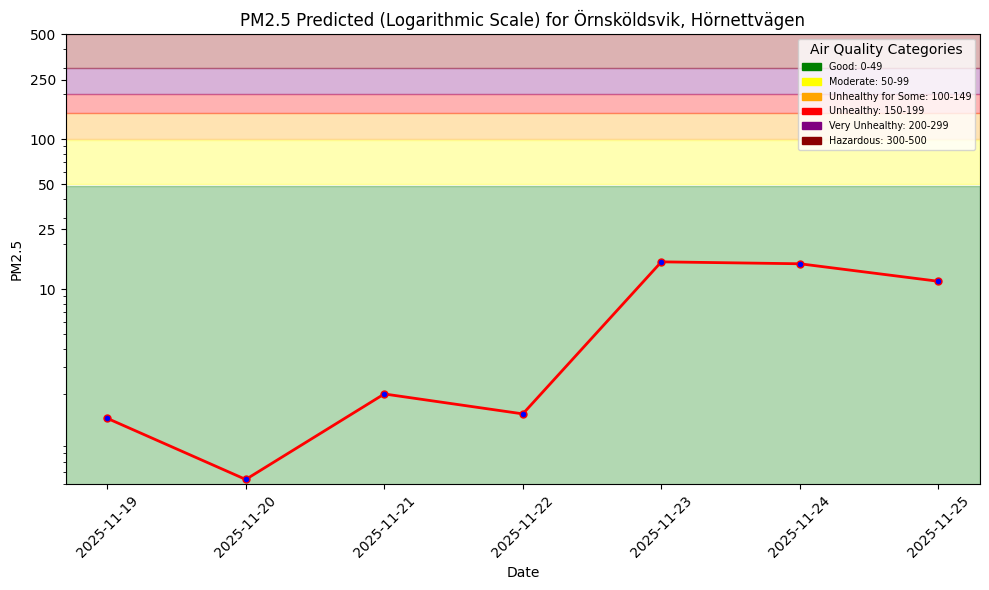

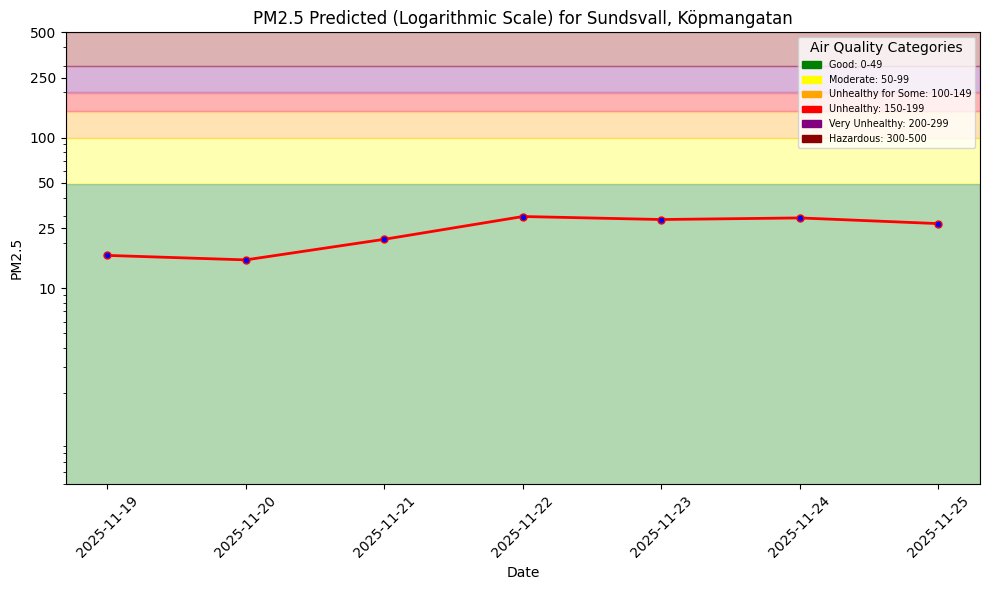

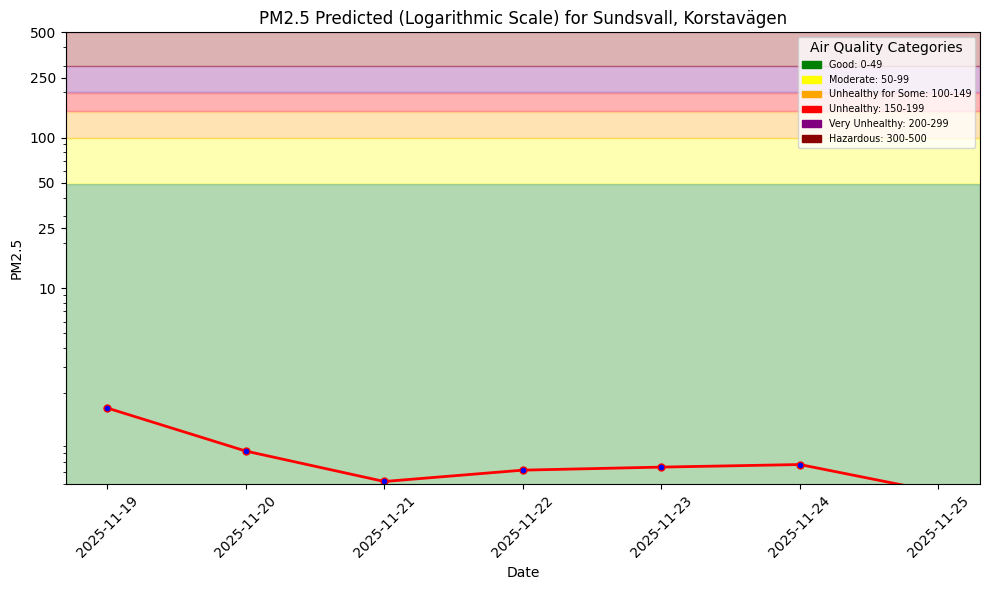

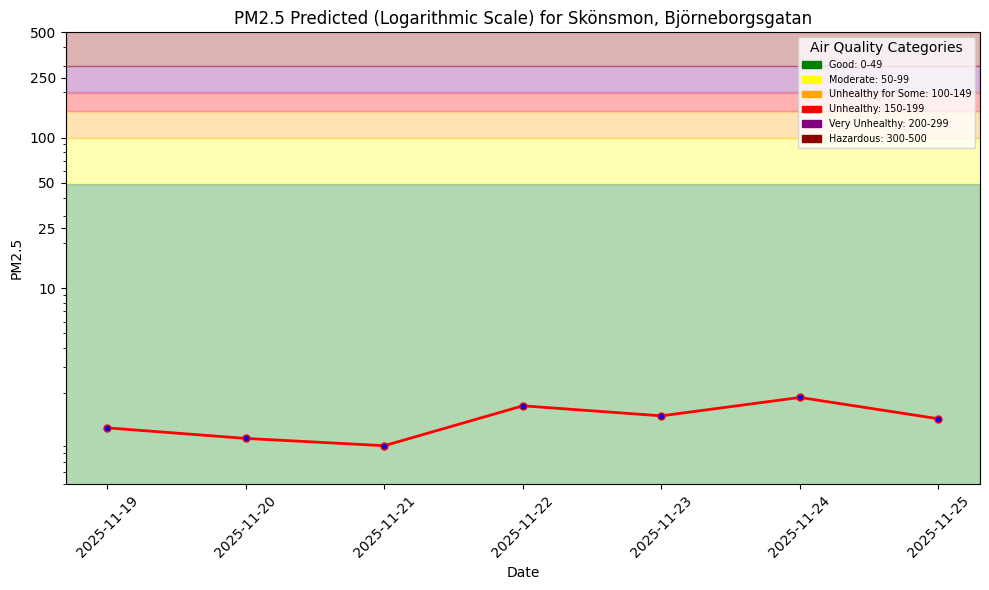

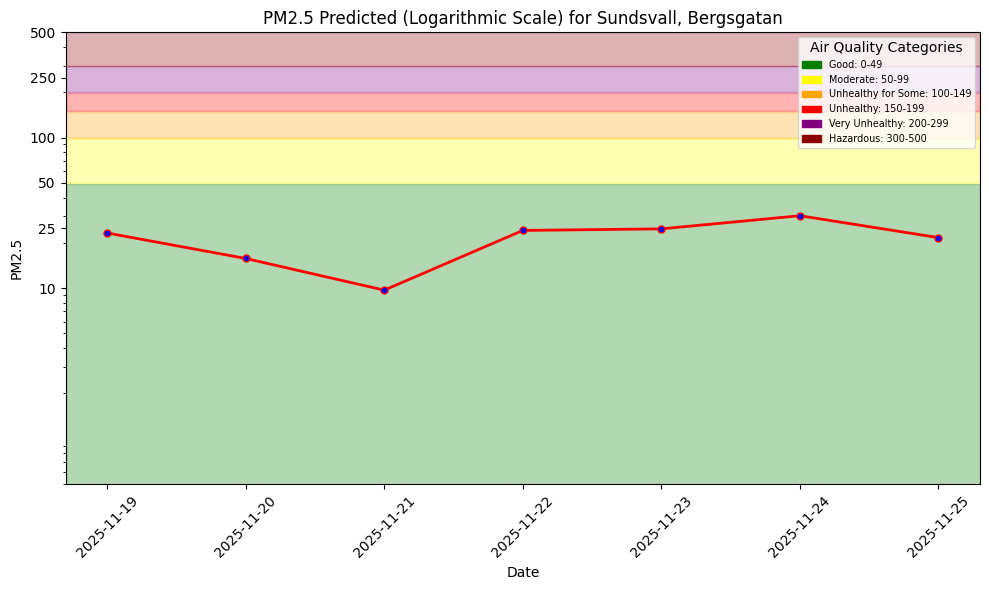

In [64]:
for key in index.keys():
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{key}.png"
    plt = util.plot_air_quality_forecast(index[key]['city'], index[key]['street'], batch_data[key], pred_file_path)
    
    plt.show()

In [65]:
b = []
for key in index.keys():
    b.append(batch_data[key])
b = pd.concat(b,axis = 0)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_sensor',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)
monitor_fg.insert(b, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286306/fs/1273933/fg/1737045


Uploading Dataframe: 100.00% |███████████████████████████████| Rows 35/35 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:40:16,718 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:40:19,901 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:41:48,609 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:41:48,767 INFO: Waiting for log aggregation to finish.
2025-11-18 11:41:57,354 INFO: Execution finished successfully.


(Job('aq_predictions_sensor_1_offline_fg_materialization', 'SPARK'), None)

In [66]:
air_quality_fg = fs.get_feature_group(name='air_quality_a', version=1)
air_quality_df = air_quality_fg.read()
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.59s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


In [67]:
monitoring_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-3.50,0.0,1.938659,21.801476,Sundsvall,Bergsgatan,8.0,5.00,33.00,23.245880,sweden,1
1,2025-11-19 00:00:00+00:00,-5.15,0.0,5.506941,348.690094,Örnsköldsvik,Hörnettvägen,0.0,0.00,4.00,1.373220,sweden,1
2,2025-11-19 00:00:00+00:00,-3.50,0.0,1.938659,21.801476,Sundsvall,Korstavägen,2.0,0.00,0.10,1.600372,sweden,1
3,2025-11-19 00:00:00+00:00,-3.50,0.0,1.938659,21.801476,Sundsvall,Köpmangatan,8.0,7.00,25.00,16.502743,sweden,1
4,2025-11-19 00:00:00+00:00,-3.65,0.0,1.938659,21.801476,Skönsmon,Björneborgsgatan,1.0,0.15,0.22,1.181224,sweden,1


In [68]:
batch_data[key].sort_values(by = 'date')

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25,country,days_before_forecast_day
8,2025-11-19 00:00:00+00:00,-3.50,0.0,1.938659,21.801476,Sundsvall,Bergsgatan,8.000000,5.000000,33.000000,23.245880,sweden,1
16,2025-11-20 00:00:00+00:00,-4.95,0.0,12.682018,325.407654,Sundsvall,Bergsgatan,23.245880,8.000000,5.000000,15.745588,sweden,2
10,2025-11-21 00:00:00+00:00,-3.50,0.0,9.504272,307.304016,Sundsvall,Bergsgatan,15.745588,23.245880,8.000000,9.701431,sweden,3
6,2025-11-22 00:00:00+00:00,-1.25,0.1,3.219938,63.435013,Sundsvall,Bergsgatan,9.701431,15.745588,23.245880,24.175407,sweden,4
27,2025-11-23 00:00:00+00:00,-1.45,0.0,5.154416,167.905258,Sundsvall,Bergsgatan,24.175407,9.701431,15.745588,24.766762,sweden,5
3,2025-11-24 00:00:00+00:00,1.15,0.2,9.885262,10.491434,Sundsvall,Bergsgatan,24.766762,24.175407,9.701431,30.273359,sweden,6
33,2025-11-25 00:00:00+00:00,-1.85,0.0,10.464797,319.185028,Sundsvall,Bergsgatan,30.273359,24.766762,24.175407,21.663090,sweden,7


In [69]:
import importlib
from mlfs.airquality import util
importlib.reload(util)
hindcast_df = dict()
for key in index.keys():
    outcome_df = air_quality_df[air_quality_df['street'] == index[key]['street']][['date', 'pm25']]
    preds_df =  monitoring_df[monitoring_df['street'] == index[key]['street']][['date', 'predicted_pm25']]
    
    hindcast_df[key] = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df[key] = hindcast_df[key].sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df[key]) == 0:
        hindcast_df[key] = util.backfill_predictions_for_monitoring_predicted(weather_fg, air_quality_df[air_quality_df['street'] == index[key]['street']], monitor_fg, retrieved_xgboost_model[key],index[key]['country'],index[key]['city'],index[key]['street'],index[key]['url'])

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 
2025-11-18 11:42:03,827 WARNING: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:42:19,341 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 11:42:22,549 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:42:25,730 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:43:54,460 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:43:54,616 INFO: Waiting for log aggregation to finish.
2025-11-18 11:44:06,491 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 
2025-11-18 11:44:08,901 WARNING: UserWarning: Boolean Series key will be reindexed t

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:44:23,928 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 11:44:27,105 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:45:46,370 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 11:45:49,532 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:45:49,707 INFO: Waiting for log aggregation to finish.
2025-11-18 11:45:58,254 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.05s) 
2025-11-18 11:46:01,242 WARNING: UserWarning: Boolean Series key will be reindexed 

Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:46:18,803 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:46:22,011 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:48:07,191 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:48:07,341 INFO: Waiting for log aggregation to finish.
2025-11-18 11:48:16,032 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.55s) 
2025-11-18 11:48:18,406 WARNING: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:48:34,107 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:48:37,294 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:50:03,082 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:50:03,260 INFO: Waiting for log aggregation to finish.
2025-11-18 11:50:11,792 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.71s) 
2025-11-18 11:50:14,213 WARNING: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-18 11:50:31,018 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 11:50:34,187 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:52:00,068 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:52:00,224 INFO: Waiting for log aggregation to finish.
2025-11-18 11:52:08,817 INFO: Execution finished successfully.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

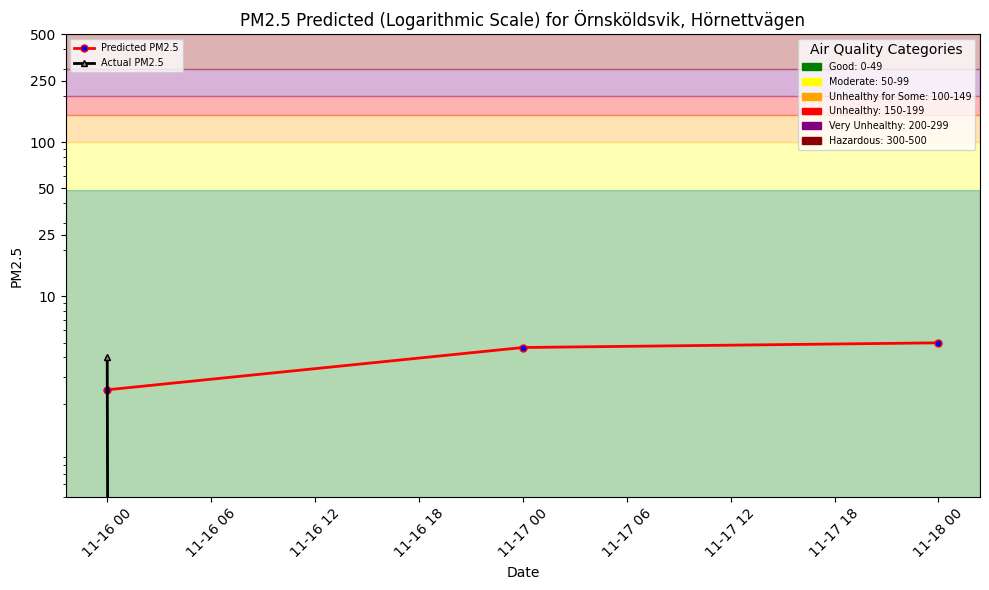

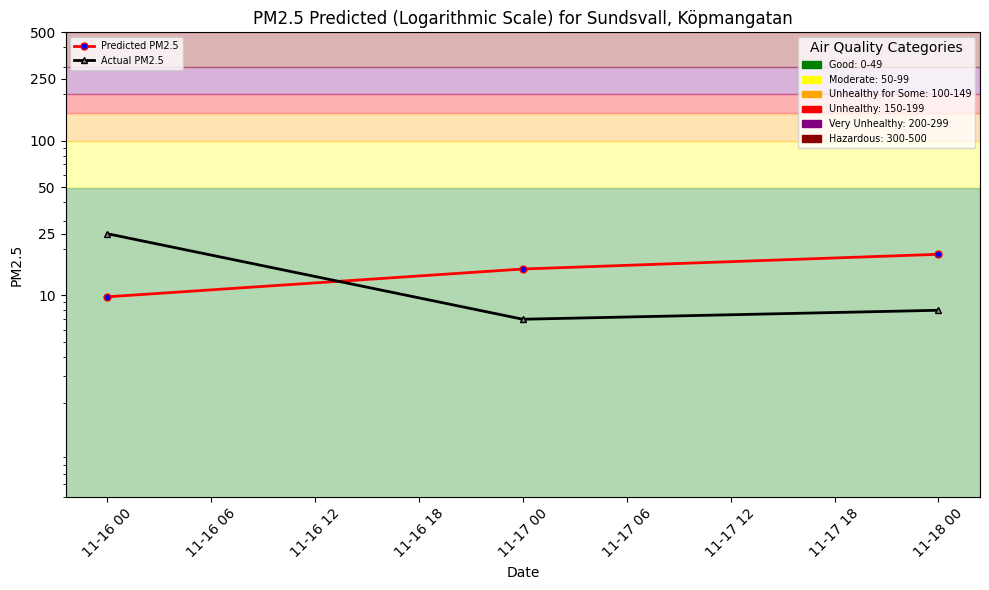

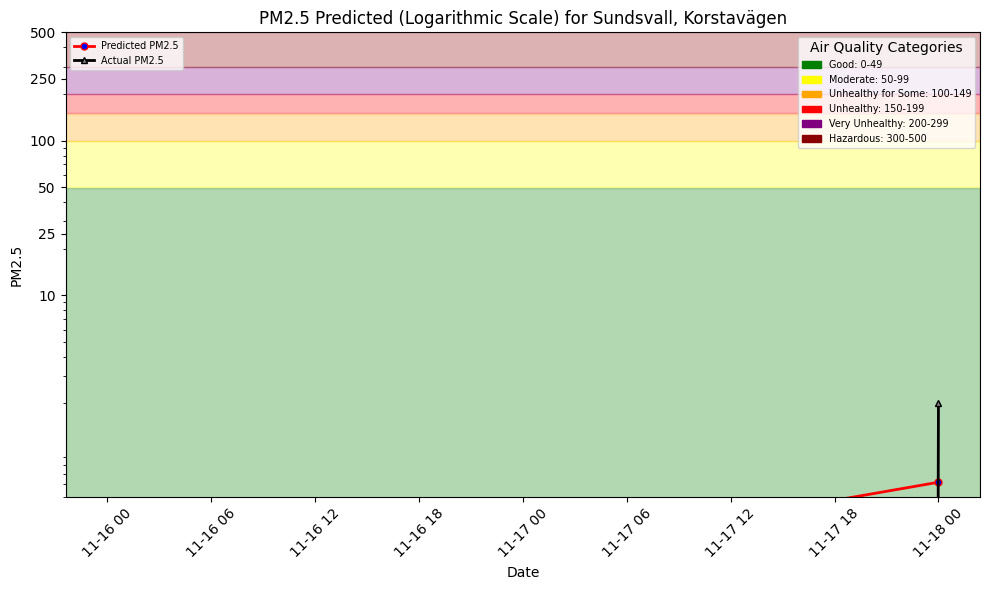

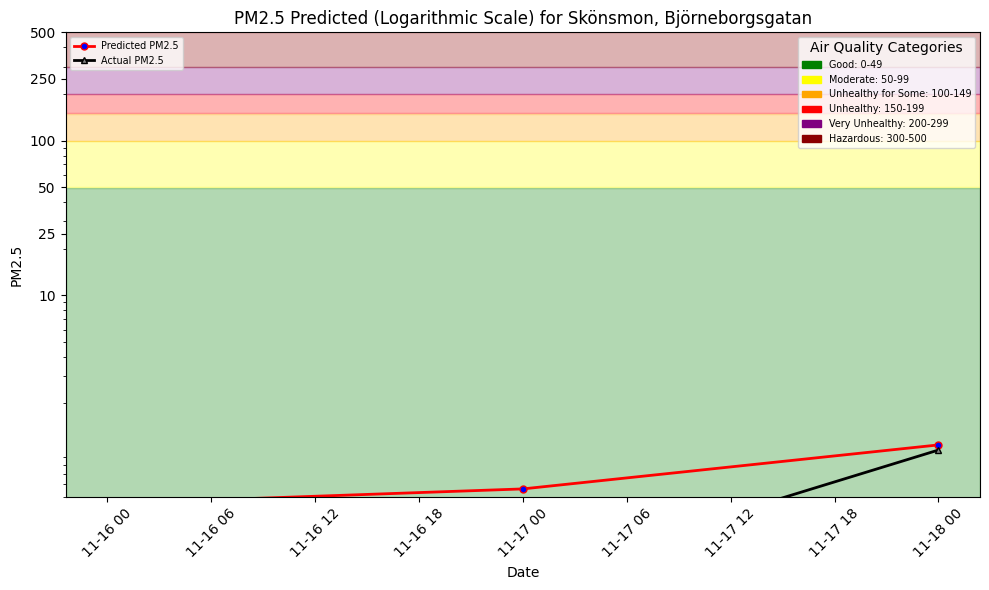

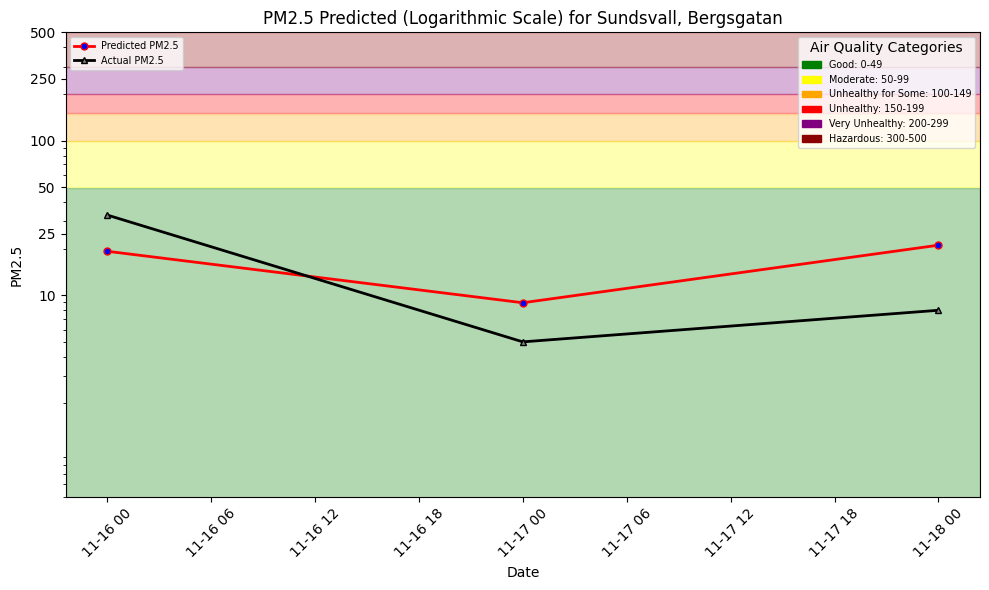

In [70]:
for key in index.keys():
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{key}.png"
    plt = util.plot_air_quality_forecast(index[key]['city'], index[key]['street'], hindcast_df[key], hindcast_file_path, hindcast=True)
    plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [71]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a/docs/air-quality/assets/img/pm25_forecast_sensor_5.…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a/docs/air-quality/assets/img/pm25_hindcast_1day_sens…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286306/settings/fb/path/Resources/airquality


---